Milvus 中的元数据过滤

In [2]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from dotenv import load_dotenv
import os

load_dotenv()

llm = ChatOpenAI(
    api_key=os.getenv("BL_API_KEY"),
    base_url=os.getenv("BL_BASE_URL"),
    model='qwen-max-latest',
    temperature=0.0
)

embed_model = OpenAIEmbeddings(
    api_key=os.getenv("BL_API_KEY"),
    base_url=os.getenv("BL_BASE_URL"),
    model="text-embedding-v3",
    dimensions=1024,
    check_embedding_ctx_length=False
)

In [3]:
# 定义向量数据库
from langchain_milvus import Milvus, BM25BuiltInFunction

vector_store = Milvus(
    collection_name='hybrid_hotpotqa500_hnsw',
    embedding_function=embed_model,
    builtin_function=BM25BuiltInFunction(output_field_names='sparse'),
    vector_field=['dense', 'sparse']
)

In [4]:
client = vector_store.client

In [ ]:
client.search(
    
)

In [6]:
import os

os.listdir('../output')

['中恒电气-公司研究报告-HVDC方案领头羊AI浪潮下迎新机-25071124页',
 '亚翔集成-公司研究报告-迎接海外业务重估-25071324页',
 '亿欧中国企业出海沙特季度研究报告-AI专题2025Q267页',
 '伊利专业乳品2022中国现制茶饮渠道消费者与行业趋势报告40页',
 '伊利股份-产业周期叠加内生动力业绩增速向上-21093038页',
 '伊利股份-产品升级叠加费用率下降盈利能力持续提升-22041256页',
 '伊利股份-公司深度报告王者荣耀行稳致远-22021459页',
 '伊利股份-公司研究专题报告高股息铸盾景气度为矛当前重点推荐-23051519页',
 '伊利股份-公司研究报告-平台化的乳企龙头引领行业高质量转型-25071638页',
 '伊利股份-公司研究报告黑夜终将过去把握高股息低估值乳品龙头机会-24110830页',
 '伊利股份-大象起舞龙头远航-2020072627页',
 '伊利股份-格局之变提供发展机遇内生外延打造第二曲线-22052743页',
 '伊利股份-王者之路扶摇而上-21083136页',
 '伊利股份-长期规划核心逻辑清晰十年问鼎全球乳业新高点1-21070625页',
 '伊利股份内蒙古伊利实业集团股份有限公司2024年年度报告',
 '伊利股份内蒙古伊利实业集团股份有限公司2024年第三季度报告',
 '伊利股份内蒙古伊利实业集团股份有限公司2025年第一季度报告',
 '伊利股份多元优势铸造乳企龙头未来战略目标平稳推进42页',
 '伟星股份-公司首次覆盖服饰辅料龙头柔性制造打造核心竞争力-25071313页',
 '传音控股-公司研究报告-非洲手机领军者多元化布局品类扩张生态链延伸打开成长空间-25071636页',
 '儒竞科技-公司研究报告-热泵控制器领导者新能车热管理及自动化构筑新增长曲线-25071036页',
 '光明肉业-公司首次覆盖报告国潮新消费重塑百年老字号牛周期向上重视经营拐点-25071631页',
 '公司研究伊利股份-上市公司深度温故知新走向全球化多元化的新伊利-2020021044页',
 '公司研究伊利股份-乳制品龙头国际赛道扬帆起航-2020031831页',
 '公司研究伊利股份-优势品牌活力依然跨品发展长远可期-2020012029页',
 '公

In [11]:
import sys

sys.path.append('../')

In [12]:
import os
from dotenv import load_dotenv

from langchain_openai import ChatOpenAI, OpenAIEmbeddings

load_dotenv()

_embed_model = OpenAIEmbeddings(
        api_key=os.getenv("BL_API_KEY"),
        base_url=os.getenv("BL_BASE_URL"),
        model="text-embedding-v4",
        dimensions=1024,
        check_embedding_ctx_length=False
)
_vlm = ChatOpenAI(
        api_key=os.getenv("BL_API_KEY"),
        base_url=os.getenv("BL_BASE_URL"),
        model='qwen-vl-max-2025-08-13',
        temperature=0.0
)
_llm = ChatOpenAI(
    api_key=os.getenv("BL_API_KEY"),
    base_url=os.getenv("BL_BASE_URL"),
    model='qwen-plus-latest',
    temperature=0.0
)
llm_nmk = ChatOpenAI(
    api_key=os.getenv("BL_API_KEY_NMK1"),
    base_url=os.getenv("BL_BASE_URL"),
    model='qwen-plus-latest',
    temperature=0.0
)

In [14]:
from modules.index.index import Index

mrag_index = Index(
        files_path=[''],
        embed_model=_embed_model,
        vlm=_vlm,
        llm=_llm,
        llm_nmk=llm_nmk,
        vector_store_name='mrag'
    )

mrag_index.get_index_done()

2025-08-25 16:03:55.702 | INFO     | modules.index.index:get_index_done:104 - mrag 向量数据库已存在，成功加载到内存中


In [16]:
# 获得 Naive RAG 图
from naive_rag.workflow import get_naive_rag_workflow
from modules.retriever import Retriever

from langgraph.checkpoint.memory import MemorySaver

# 获得带有短期记忆的 Naive RAG 图
memory = MemorySaver()
naive_rag_wf = get_naive_rag_workflow()
# naive_rag = naive_rag_wf.compile(checkpointer=memory)
naive_rag = naive_rag_wf.compile()

# 定义检索器
rerank_model_retriever = Retriever(
    vector_store=mrag_index.vector_store,
    topk=3,
    filter_='page > "0"',
    search_fields=['dense', 'sparse'],
    search_type='hybrid',
    search_params=[
        {'metric_type': 'L2', 'params': {'ef': 21}},
        {'params': {'drop_ratio_search': 0.2}}
    ],
    ranker_type='model',
    ranker_params={
        'model_name': 'gte-rerank-v2',
        'pre_topk': 10,
        'pre_ranker_type': 'rrf',
        'pre_ranker_params': {'k': 60}  # 定义粗排所使用的重排序参数，粗排只能使用 weighted 或 rrf
    }
)

# 定义运行时配置
config = {
    'configurable': {
        'retriever': rerank_model_retriever,
        'llm': llm_nmk,
        # 'thread_id': '-1'
    }
}

In [18]:
import json

test_file_path = './test.json'
with open(test_file_path, 'r', encoding='utf-8') as f:
    queries = json.load(f)

len(queries)

806

In [26]:
from typing import List, TypedDict
from langgraph.graph import START, StateGraph, END
from langgraph.graph.state import Send

class SendState(TypedDict):
    queries: List[str]

def tmp():
    pass

def send_queries(state: SendState):
    for i in range(0, len(state['queries']), 10):
        cur_queries = state['queries'][i:i+10]
        return [
            Send(
                ['naive_rag'],
                {
                    'query': query,
                }
            )
            for query in cur_queries
        ]

send_wf = StateGraph(StateGraph)

send_wf.add_node('tmp', tmp)
send_wf.add_node('naive_rag', naive_rag)

send_wf.add_edge(START, 'tmp')
send_wf.add_conditional_edges(
    'tmp',
    send_queries,
    ['naive_rag']
)
send_wf.add_edge('naive_rag', END)

g = send_wf.compile()


In [27]:
g.invoke(
    input={'queries': queries[:10]},
    config=config
)

InvalidUpdateError: Must write to at least one of ['nodes', 'channels', 'managed', 'schemas']

Failed to multipart ingest runs: langsmith.utils.LangSmithRateLimitError: Rate limit exceeded for https://api.smith.langchain.com/runs/multipart. HTTPError('429 Client Error: Too Many Requests for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Too many requests: tenant exceeded usage limits: Monthly unique traces usage limit exceeded"}\n')trace=adff1023-a859-4a64-9e2c-a8e2a71299b2,id=adff1023-a859-4a64-9e2c-a8e2a71299b2; trace=adff1023-a859-4a64-9e2c-a8e2a71299b2,id=02c489e2-6edd-4582-b373-8cf17a65522b; trace=adff1023-a859-4a64-9e2c-a8e2a71299b2,id=343c2e82-31e4-4ea1-af48-57d6d66ab486


In [1]:
import sys

sys.path.append('../')

In [2]:
import json
from tqdm import tqdm
from dotenv import load_dotenv
from typing import (
    TypedDict,
    List
)
import os

from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_milvus import Milvus, BM25BuiltInFunction
from langgraph.graph.state import START, StateGraph, END
from langgraph.types import Send

from naive_rag.workflow import get_naive_rag_workflow
from modules.retriever import Retriever

load_dotenv()

# 定义图的运行时配置
# 定义 LLM、vector store、retriever
llm = ChatOpenAI(
    api_key=os.getenv("BL_API_KEY"),
    base_url=os.getenv("BL_BASE_URL"),
    model='qwen-plus-latest',
    temperature=0.0
)
embed_model = OpenAIEmbeddings(
    api_key=os.getenv("BL_API_KEY"),
    base_url=os.getenv("BL_BASE_URL"),
    model="text-embedding-v4",
    dimensions=1024,
    check_embedding_ctx_length=False
)
# 定义向量场的索引参数
dense_index_parma = {
    "metric_type": "L2",
    "index_type": "HNSW",
    "params": {
        "M": 64,
        "efConstruction": 400
    }
}
sparse_index_param = {
    "metric_type": "BM25",
    "index_type": "AUTOINDEX",
    "params": {}
}
vector_store = Milvus(
    collection_name='mrag',
    embedding_function=embed_model,
    builtin_function=BM25BuiltInFunction(output_field_names='sparse'),
    vector_field=['dense', 'sparse'],
    index_params=[dense_index_parma, sparse_index_param]  # 顺序关系是对应的
)
rerank_model_retriever = Retriever(
    vector_store=vector_store,
    topk=3,
    search_fields=['dense', 'sparse'],
    search_type='hybrid',
    search_params=[
        {'metric_type': 'L2', 'params': {'ef': 21}},
        {'params': {'drop_ratio_search': 0.2}}
    ],
    ranker_type='model',
    ranker_params={
        'model_name': 'gte-rerank-v2',
        'pre_topk': 10,
        'pre_ranker_type': 'rrf',
        'pre_ranker_params': {'k': 60}  # 定义粗排所使用的重排序参数，粗排只能使用 weighted 或 rrf
    }
)


In [3]:
# 定义一个父图，包裹 Naive RAG
class SendState(TypedDict):
    queries: List[str]


def send_queries(state: SendState):
    return [
        Send(
            'naive_rag',
            {
                'query': query
            }
        ) for query in state['queries']
    ]

def tmp(state: SendState):
    return 


def get_send_workflow():
    wf = StateGraph(SendState)

    wf.add_node('naive_rag', get_naive_rag_workflow().compile())

    # wf.add_edge(START, 'tmp')
    wf.add_conditional_edges(
        START,
        send_queries,
        ['naive_rag']
    )
    wf.add_edge('naive_rag', END)

    return wf



In [4]:
config = {
    'configurable': {
        'retriever': rerank_model_retriever,
        'llm': llm,
    }
}

# 定义图
send_wf = get_send_workflow()
graph = send_wf.compile()

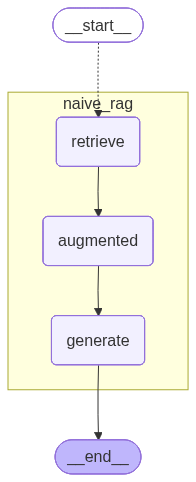

In [5]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [6]:
# 加载问题
test_file_path = './test.json'
with open(test_file_path, 'r', encoding='utf-8') as f:
    test_datas = json.load(f)

test_datas = test_datas[:3]
print(test_datas)

[{'filename': 'xx.pdf', 'page': 1, 'question': '广联达在苏中建设集团南宁龙湖春江天越项目中，具体运用了哪些BIM技术，并取得了哪些成果？', 'answer': '广联达在苏中建设集团南宁龙湖春江天越项目中，具体运用了哪些BIM技术，并取得了哪些成果？'}, {'filename': 'xx.pdf', 'page': 1, 'question': '广联达公司如何通过数字项目管理平台提升施工企业的数字化转型能力？', 'answer': '广联达公司如何通过数字项目管理平台提升施工企业的数字化转型能力？'}, {'filename': 'xx.pdf', 'page': 1, 'question': '广联达公司的BIM技术在中国建筑业中的应用现状如何？', 'answer': '广联达公司的BIM技术在中国建筑业中的应用现状如何？'}]


In [7]:
for i in tqdm(range(0, len(test_datas), 3), desc='回答'):
    batch_queries = test_datas[i:i+10]
    queries = [test_data['question'] for test_data in batch_queries]
    print(queries)

    graph.invoke(
        input={'queries': queries},
        config=config
    )

回答:   0%|          | 0/1 [00:00<?, ?it/s]

['广联达在苏中建设集团南宁龙湖春江天越项目中，具体运用了哪些BIM技术，并取得了哪些成果？', '广联达公司如何通过数字项目管理平台提升施工企业的数字化转型能力？', '广联达公司的BIM技术在中国建筑业中的应用现状如何？']


2025-08-25 19:34:39.596 | INFO     | naive_rag.nodes:generate_node:110 - 广联达公司如何通过数字项目管理平台提升施工企业的数字化转型能力？
2025-08-25 19:34:40.159 | INFO     | naive_rag.nodes:generate_node:110 - 广联达在苏中建设集团南宁龙湖春江天越项目中，具体运用了哪些BIM技术，并取得了哪些成果？
2025-08-25 19:34:43.561 | INFO     | naive_rag.nodes:generate_node:110 - 广联达公司的BIM技术在中国建筑业中的应用现状如何？
回答: 100%|██████████| 1/1 [00:10<00:00, 10.82s/it]


In [8]:
queries = 'a'

In [9]:
queries

'a'

In [ ]:
# 处理向量数据库中的错误，包括
# 1. 当时由于解析错误，图片的内容为 ‘图片解析错误’
# 2. 由于解析错误，表格的内容为 ‘表格解析错误’
# 3. 两个错误很多的文件：连连数字-港股公司研究报告-全球化牌照与稳定币创新双轮驱动跨境支付巨头迎盈利拐点-25071428页.pdf
#                      微光股份-公司首次覆盖深度报告电机主业地位稳固机器人打造增长新引擎-25071418页.pdf

In [9]:
search_data = embed_model.embed_query('解析错误')

In [34]:
# 删除这两个文件对应的实体

a = vector_store.client.search(
    collection_name='mrag',
    data=[search_data],
    filter='filename == "连连数字-港股公司研究报告-全球化牌照与稳定币创新双轮驱动跨境支付巨头迎盈利拐点-25071428页.pdf"',
    limit=200,
    anns_field='dense',
    output_fields=['filename', 'text']
)

In [35]:
a

data: [[]]

In [33]:
len(a), type(a)

(1, pymilvus.client.search_result.SearchResult)

In [32]:
a

data: [[{'pk': 'f09b3b00-f915-40d7-982c-a9fd49407e7f', 'distance': 0.9258251786231995, 'entity': {'filename': '微光股份-公司首次覆盖深度报告电机主业地位稳固机器人打造增长新引擎-25071418页.pdf', 'text': "图片解析错误\nitem: {'type': 'image', 'img_path': 'images/07f8b7e39b92d302b0fd0ea7871bcb78070e962db27dd9315cba7ca402b43722.jpg', 'image_caption': ['图5:公司分产品毛利率情况（重分类）', '资料来源：iFind，甬兴证券研究所注：2020年\\\\~2023年制冷电机及风机采用ECM电机、冷柜电机、磷酸铁锂、汽车空调机组、外转子风机五项总和'], 'image_footnote': [], 'page_idx': 6, 'filename': '微光股份-公司首次覆盖深度报告电机主业地位稳固机器人打造增长新引擎-25071418页.pdf'}"}}, {'pk': 'd619e799-87b8-4c6b-a9f2-75b3f35ef26e', 'distance': 0.9448670148849487, 'entity': {'filename': '微光股份-公司首次覆盖深度报告电机主业地位稳固机器人打造增长新引擎-25071418页.pdf', 'text': "图片解析错误\nitem: {'type': 'image', 'img_path': 'images/56a79dde64f73eddff4c88eba8863ceb971cae64d230ffe9636e02cb2bd53a1c.jpg', 'image_caption': ['图4:公司分产品营收情况（亿元）（重分类)', '资料来源：iFind，甬兴证券研究所注：2020年\\\\~2023年制冷电机及风机采用ECM电机、冷柜电机、磷酸铁锂、汽车空调机组、外转子风机五项总和'], 'image_footnote': [], 'page_idx': 6, 'filename': '微光股份-公司首次覆盖深度报告电机主业地位稳固

In [37]:
from run_test import parse_answers

parse_answers()

In [3]:
import re

In [4]:
# 文本清洗函数
def clean_text(text):
    # 1. 转换为小写（处理可能的英文答案）
    text = text.lower()
    # 2. 移除所有标点符号和空格
    # 匹配所有非汉字、非字母、非数字的字符
    cleaned = re.sub(r'[^\u4e00-\u9fff\w]', '', text)
    return cleaned

In [6]:
# a = '根据伊利股份的公司深度报告《王者荣耀行稳致远》，伊利在2005年后通过以下营销策略实现了后来居上：\n\n1. **拿下北京奥运会官方合作伙伴**：在2008年成为北京奥运会官方合作伙伴。\n2. **综艺节目合作**：在2013年综艺节目逐渐成为新的流量入口后，把握住了中国好声音、奔跑吧兄弟、爸爸去哪儿等爆款节目，逐渐占据营销的上风。\n\n这些策略帮助伊利在2005年后实现了后来居上。'

a = '根据《伊利股份-公司深度报告》中的内容，影响奶粉行业规模的主要因素包括：\n\n1. **新生儿的数量**：近年来新生儿数量下滑严重，成为影响行业规模最主要的因素。这主要是由于人口结构变化和生育时间推迟导致的。\n\n2. **0-6个月的纯母乳哺乳率**：虽然2017年我国0-6个月纯母乳哺乳率约为29%，与发达国家接近，但由于哺乳率高的国家多为欠发达国家，因此我国的哺乳率上升空间不大。\n\n3. **各段奶粉的人均消费量**：各段奶粉人均消费'

clean_text(a)

'根据伊利股份公司深度报告中的内容影响奶粉行业规模的主要因素包括1新生儿的数量近年来新生儿数量下滑严重成为影响行业规模最主要的因素这主要是由于人口结构变化和生育时间推迟导致的206个月的纯母乳哺乳率虽然2017年我国06个月纯母乳哺乳率约为29与发达国家接近但由于哺乳率高的国家多为欠发达国家因此我国的哺乳率上升空间不大3各段奶粉的人均消费量各段奶粉人均消费'

In [7]:
import re

def get_answer_score(pred_answer: str, gt_answer: str) -> float:
    """
    计算预测答案与真实答案的Jaccard相似系数（字符级），先进行中文文本清洗
    
    清洗操作：
    - 移除所有标点符号（中英文标点）
    - 移除所有空格（包括全角/半角空格）
    - 保留汉字、字母和数字
    - 转换为小写（处理可能的英文答案）
    
    参数:
    pred_answer (str): 预测答案字符串
    gt_answer (str): 真实答案字符串
    
    返回:
    float: Jaccard相似系数，范围[0, 1]
    """
    # 文本清洗函数
    def clean_text(text):
        # 1. 转换为小写（处理可能的英文答案）
        text = text.lower()
        # 2. 移除所有标点符号和空格
        # 匹配所有非汉字、非字母、非数字的字符
        cleaned = re.sub(r'[^\u4e00-\u9fff\w]', '', text)
        return cleaned
    
    # 清洗两个答案
    clean_pred = clean_text(pred_answer)
    clean_gt = clean_text(gt_answer)
    
    # 转换为字符集合（自动去重）
    set_pred = set(clean_pred)
    set_gt = set(clean_gt)
    
    # 计算交集和并集大小
    intersection_size = len(set_pred & set_gt)
    union_size = len(set_pred | set_gt)
    
    # 处理全空情况（两个空字符串相似度为1.0）
    if union_size == 0:
        return 1.0
    
    # 计算Jaccard相似系数
    return intersection_size / union_size

In [8]:
b = '根据伊利股份公司深度报告中的内容'

get_answer_score(a, b)

0.1568627450980392